# Carga de librerías

In [1]:
import pandas as pd
import numpy as np # versión 1.26.4 incompatible con opencv-python 4.12.0.88
import matplotlib.pylab as plt
from shapely import wkt
from shapely.geometry import Point
from PIL import Image
import squarify
import colorsys
import cv2
import json
import os
from os import listdir
from os.path import isfile, join
from collections import Counter
import re
import warnings
from pathlib import Path
from glob import glob
import os
from pathlib import Path
import json

import torch
from torch.cuda.amp import autocast
import numpy as np

warnings.filterwarnings(action='ignore', category=FutureWarning, 
                        message=r".*Use a DatetimeIndex.*")

warnings.filterwarnings(action='ignore', category=UserWarning)
pd.options.mode.copy_on_write = True

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from torch.amp import autocast, GradScaler

print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())




Torch: 2.5.1+cu124
CUDA available: True


# Data load


In [2]:
exp_dirs = [
    Path("/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_Adam_e90_lr0.0001_wd1e-05"),
    Path("/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_Adam_e135_lr0.0001_wd1e-05"),
    Path("/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_AdamW_e90_lr0.0001_wd1e-05"),
    Path("/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_AdamW_e135_lr0.0001_wd1e-05"),
]

In [3]:
rows = []

for d in exp_dirs:
    summary_path = d / "summary.json"
    with open(summary_path, "r") as f:
        summary = json.load(f)

    row = {"experiment": d.name}
    row.update(summary)   # afegim totes les claus del summary
    rows.append(row)

df_summary = pd.json_normalize(rows)  # per si hi ha claus niuades
df_summary

,experiment,tag,duration_seconds,paths.exp_dir,paths.best_ckpt,paths.train_log,hyperparams.optimizer,hyperparams.epochs,hyperparams.lr_backbone,hyperparams.lr_head_multiplier,...,metrics.per_class_IoU.sidewalk_tiles,metrics.per_class_IoU.sidewalk_asphalt,metrics.per_class_IoU.roadway,metrics.per_class_IoU.curb_edge,metrics.per_class_IoU.drainage_inlet,metrics.per_class_IoU.gutter,metrics.per_class_IoU.access_cover,metrics.per_class_IoU.tree_pit,metrics.per_class_IoU.vegetation,metrics.per_class_IoU.street_furniture
0,exp_Adam_e90_lr0.0001_wd1e-05,Adam_e90_lr0.0001_wd1e-05,3769.25,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,Adam,90,0.0001,10.0,...,0.893667,0.383642,0.652696,0.560594,0.539828,0.566197,0.491551,0.651768,0.630630,0.587360
1,exp_Adam_e135_lr0.0001_wd1e-05,Adam_e135_lr0.0001_wd1e-05,3405.87,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,Adam,135,0.0001,10.0,...,0.877726,0.356284,0.637747,0.516347,0.426047,0.468825,0.449691,0.527176,0.623368,0.559917
2,exp_AdamW_e90_lr0.0001_wd1e-05,AdamW_e90_lr0.0001_wd1e-05,2247.13,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,AdamW,90,0.0001,10.0,...,0.873413,0.321678,0.614983,0.454634,0.437551,0.427960,0.576093,0.620634,0.523578,0.522306
3,exp_AdamW_e135_lr0.0001_wd1e-05,AdamW_e135_lr0.0001_wd1e-05,3189.00,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/...,AdamW,135,0.0001,10.0,...,0.845224,0.224892,0.538340,0.533214,0.542087,0.438395,0.508852,0.497102,0.629465,0.603274


# Logs y métricas de clases

In [4]:
# --- Config ---
class Cfg:
    data_root = '/home/joan_ds/Sandbox/UOC/TFM/data/dataset_500_GT'  # TODO: set your path
    work_dir  = '/home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3'
    mode      = 'labelme'  # 'labelme' or 'png'
    cityscapes_ckpt_for_ft = ''
    img_size  = (768, 768)
    batch_size  = 2
    num_workers = 2
    cache_png_masks = True
    CLASS_TO_INDEX = {
        'sidewalk_tiles': 0,
        'sidewalk_asphalt': 1,
        'roadway': 2,
        'curb_edge': 3,
        'drainage_inlet': 4,
        'gutter': 5,
        'access_cover': 6,
        'tree_pit': 7,
        'vegetation': 8,
        'street_furniture': 9
    }
    ignore_index = 255
    epochs_grid  = [90, 135]
    lr_base_grid = [1e-4]
    opt_grid     = ['AdamW', 'Adam']

cfg = Cfg()
cfg.num_classes = len(cfg.CLASS_TO_INDEX)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Path(cfg.work_dir).mkdir(parents=True, exist_ok=True)
IDX_TO_CLASS = {v: k for k, v in cfg.CLASS_TO_INDEX.items()}
print('Classes:', cfg.CLASS_TO_INDEX)
print('Work dir:', cfg.work_dir)


Classes: {'sidewalk_tiles': 0, 'sidewalk_asphalt': 1, 'roadway': 2, 'curb_edge': 3, 'drainage_inlet': 4, 'gutter': 5, 'access_cover': 6, 'tree_pit': 7, 'vegetation': 8, 'street_furniture': 9}
Work dir: /home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3


In [5]:
# --- Dataset class (LabelMe or PNG) ---
class SegDataset(Dataset):
    def __init__(self, root, split='train', mode='labelme', img_size=(768,768), augment=False, cache=False, class_to_index=None, ignore_val=255):
        self.root = Path(root)
        self.split = split
        self.mode = mode
        self.img_dir = self.root / 'images' / split
        self.seg_dir = self.root / ('segmaps' if mode=='png' else 'labelme') / split
        self.imgs = sorted([p for p in self.img_dir.glob('*') if p.suffix.lower() in ['.jpg','.jpeg','.png','.bmp']])
        self.size = img_size
        self.augment = augment
        self.class_to_index = class_to_index or {}
        self.ignore_val = ignore_val

        self.cache = cache and (mode=='labelme')
        self.cache_dir = self.root / '_cache_png' / split if self.cache else None
        if self.cache_dir: self.cache_dir.mkdir(parents=True, exist_ok=True)

        self.norm = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        name = img_path.stem

        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        assert img is not None, f"Image not found: {img_path}"
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.mode == 'png':
            seg_path = self.seg_dir / f'{name}.png'
            seg = cv2.imread(str(seg_path), cv2.IMREAD_UNCHANGED)
            assert seg is not None, f"Mask not found: {seg_path}"
            if seg.ndim == 3:
                seg = seg[:,:,0]
        else:
            cache_path = self.cache_dir / f'{name}.png' if self.cache_dir else None
            if cache_path and cache_path.exists():
                seg = cv2.imread(str(cache_path), cv2.IMREAD_UNCHANGED)
            else:
                json_path = self.seg_dir / f'{name}.json'
                assert json_path.exists(), f"LabelMe JSON not found: {json_path}"
                seg = labelme_to_mask(json_path, image_hw=img.shape[:2], class_to_index=self.class_to_index, ignore_val=self.ignore_val)
                if cache_path is not None:
                    cv2.imwrite(str(cache_path), seg)

        H, W = self.size
        img_r = cv2.resize(img, (W,H), interpolation=cv2.INTER_LINEAR)
        seg_r = cv2.resize(seg, (W,H), interpolation=cv2.INTER_NEAREST)

        if self.augment and random.random() < 0.5:
            img_r = np.ascontiguousarray(np.fliplr(img_r))
            seg_r = np.ascontiguousarray(np.fliplr(seg_r))

        img_t = torch.from_numpy(img_r).permute(2,0,1).float()/255.0
        img_t = self.norm(img_t)
        seg_t = torch.from_numpy(seg_r.astype(np.int64))

        return {'image': img_t, 'mask': seg_t, 'name': name}

In [6]:
def make_loaders(cfg):
    ds_tr = SegDataset(
        cfg.data_root, 'train', cfg.mode, cfg.img_size,
        augment=True,
        cache=cfg.cache_png_masks,
        class_to_index=cfg.CLASS_TO_INDEX,
        ignore_val=cfg.ignore_index
    )
    ds_va = SegDataset(
        cfg.data_root, 'val', cfg.mode, cfg.img_size,
        augment=False,
        cache=cfg.cache_png_masks,
        class_to_index=cfg.CLASS_TO_INDEX,
        ignore_val=cfg.ignore_index
    )
    dl_tr = DataLoader(ds_tr, batch_size=cfg.batch_size, shuffle=True,
                       num_workers=cfg.num_workers, pin_memory=True)
    dl_va = DataLoader(ds_va, batch_size=1, shuffle=False,
                       num_workers=cfg.num_workers, pin_memory=True)
    return ds_tr, ds_va, dl_tr, dl_va

def make_test_loader(cfg):
    ds_te = SegDataset(
        cfg.data_root, 'test', cfg.mode, cfg.img_size,
        augment=False,
        cache=cfg.cache_png_masks,
        class_to_index=cfg.CLASS_TO_INDEX,
        ignore_val=cfg.ignore_index
    )
    dl_te = DataLoader(ds_te, batch_size=1, shuffle=False,
                       num_workers=cfg.num_workers, pin_memory=True)
    return ds_te, dl_te

# Crides
ds_tr, ds_va, dl_tr, dl_va = make_loaders(cfg)
ds_te, dl_te = make_test_loader(cfg)

print(f"Train: {len(ds_tr)}   Val: {len(ds_va)}   Test: {len(ds_te)}   Mode: {cfg.mode}")

Train: 354   Val: 76   Test: 77   Mode: labelme


In [7]:
log_dfs = []

for d in exp_dirs:
    log_path = d / "train_log.jsonl"
    records = []
    with open(log_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))

    df_log = pd.DataFrame(records)
    df_log["experiment"] = d.name
    log_dfs.append(df_log)

df_logs = pd.concat(log_dfs, ignore_index=True)
df_logs.head()

,epoch,optimizer,train_loss,val_loss,val_mIoU,best_mIoU,best_epoch,lr_bb,lr_head,weight_decay,early_no_improve,early_best_val_loss,experiment
0,1,Adam,1.143085,1.044358,0.276680,0.276680,1,0.000028,0.00028,0.00001,0,1.044358,exp_Adam_e90_lr0.0001_wd1e-05
1,2,Adam,0.722615,0.822335,0.343099,0.343099,2,0.000046,0.00046,0.00001,0,0.822335,exp_Adam_e90_lr0.0001_wd1e-05
2,3,Adam,0.580893,0.674621,0.383657,0.383657,3,0.000064,0.00064,0.00001,0,0.674621,exp_Adam_e90_lr0.0001_wd1e-05
3,4,Adam,0.506773,0.641798,0.367870,0.383657,3,0.000082,0.00082,0.00001,0,0.641798,exp_Adam_e90_lr0.0001_wd1e-05
4,5,Adam,0.487471,0.646532,0.426314,0.426314,5,0.000100,0.00100,0.00001,1,0.641798,exp_Adam_e90_lr0.0001_wd1e-05


52
\begin{tabular}{l}
\toprule
44 \\
\midrule
exp_Adam_e90_lr0.0001_wd1e-05 \\
45 \\
0.595793 \\
0.602761 \\
\bottomrule
\end{tabular}



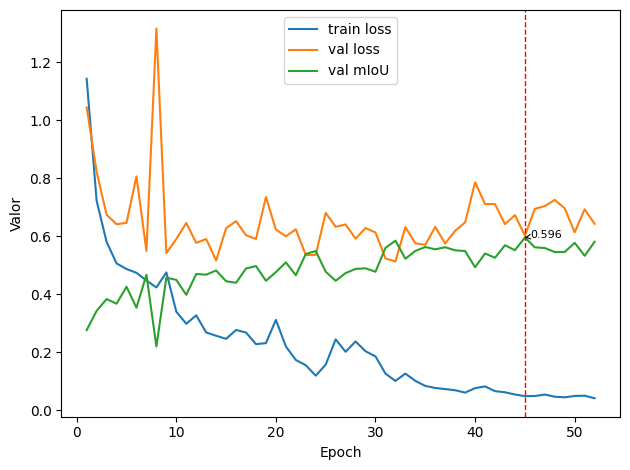

47
\begin{tabular}{l}
\toprule
78 \\
\midrule
exp_Adam_e135_lr0.0001_wd1e-05 \\
27 \\
0.544313 \\
0.528324 \\
\bottomrule
\end{tabular}



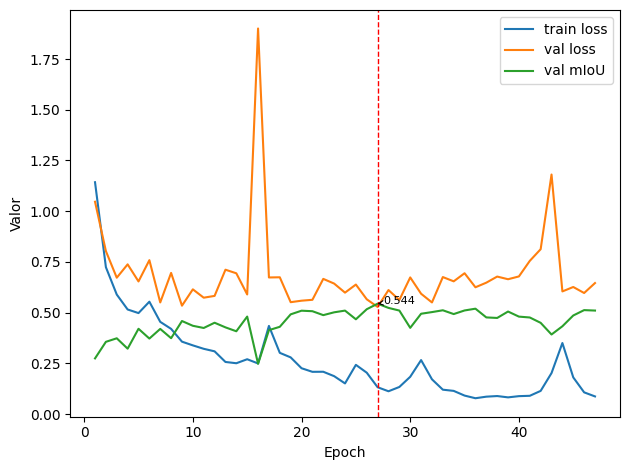

31
\begin{tabular}{l}
\toprule
128 \\
\midrule
exp_AdamW_e90_lr0.0001_wd1e-05 \\
30 \\
0.537283 \\
0.620337 \\
\bottomrule
\end{tabular}



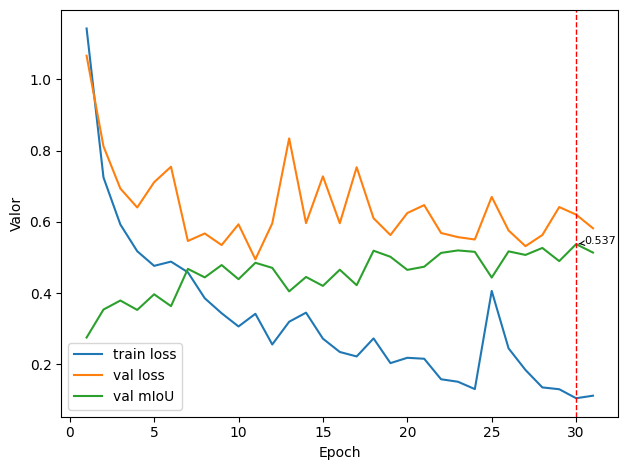

44
\begin{tabular}{l}
\toprule
154 \\
\midrule
exp_AdamW_e135_lr0.0001_wd1e-05 \\
25 \\
0.536085 \\
0.570640 \\
\bottomrule
\end{tabular}



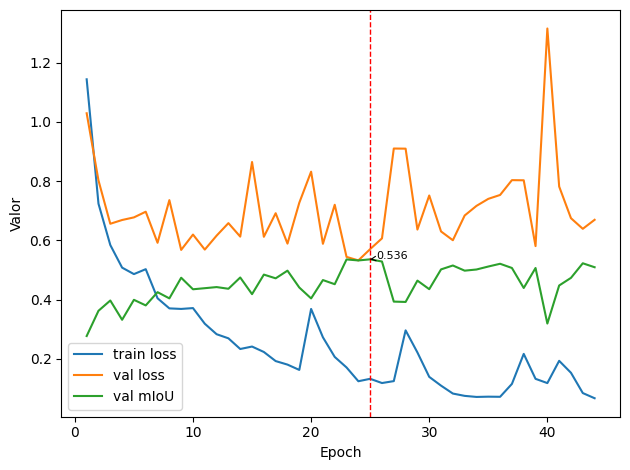

In [ ]:
experiments = ['exp_Adam_e90_lr0.0001_wd1e-05',
               'exp_Adam_e135_lr0.0001_wd1e-05',
               'exp_AdamW_e90_lr0.0001_wd1e-05',
               'exp_AdamW_e135_lr0.0001_wd1e-05']

for e in experiments:
    mask = df_logs.experiment == e
    df_ = df_logs[mask]
    print(len(df_))


    best_idx = df_["val_mIoU"].idxmax()
    best_epoch = df_.loc[best_idx, "epoch"]
    best_miou = df_.loc[best_idx, "val_mIoU"]
    latex = df_.loc[best_idx,['experiment', 'epoch', 'val_mIoU', 'val_loss']]
    
    print(latex.to_latex(escape=False, index=False))

    plt.plot(df_.epoch, df_.train_loss)
    plt.plot(df_.epoch, df_.val_loss)
    plt.plot(df_.epoch, df_.val_mIoU)

    plt.axvline(best_epoch, color="red", linestyle="--",
                linewidth=1.0, label=f"Mejor mIoU (epoch {best_epoch})")
    
    plt.annotate(f"{best_miou:.3f}",
                 xy=(best_epoch, best_miou),
                 xytext=(best_epoch + 0.5, best_miou),
                 fontsize=8,
                 arrowprops=dict(arrowstyle="->", linewidth=0.8))

    plt.xlabel("Epoch")
    plt.ylabel("Valor")
    #plt.title(e)
    plt.legend(labels=['train loss', 'val loss', 'val mIoU'])
    plt.tight_layout()
    
    plt.show()

In [9]:
# --- Label normalization, Rasterization (LabelMe) ---
PRIORITY = [
    'sidewalk_tiles','sidewalk_asphalt','roadway','curb_edge','drainage_inlet',
    'gutter','access_cover','tree_pit','vegetation','street_furniture'
]

ALIASES = {
    'street_forniture': 'street_furniture',
    'kerb': 'curb_edge',
    'curb': 'curb_edge',
    'gully': 'drainage_inlet',
    'drain': 'drainage_inlet',
    'inlet': 'drainage_inlet',
    'grate': 'drainage_inlet',
    'manhole': 'access_cover',
    'manhole_cover': 'access_cover',
    'panot': 'sidewalk_tiles',
    'asphalt': 'sidewalk_asphalt',
    'asphalt_sidewalk': 'sidewalk_asphalt',
    'bush': 'vegetation',
    'tree': 'vegetation',
    'road': 'roadway',
    'street': 'roadway',
}

def norm_label(raw):
    s = str(raw).strip().lower()
    if s in ('255','ignore','ignored','void','background','bg'):
        return None
    if s in ('0','1','2','3','4','5','6','7','8','9'):
        idx = int(s)
        return IDX_TO_CLASS.get(idx, None)
    if s in ALIASES:
        return ALIASES[s]
    return s

def draw_polygons(mask: np.ndarray, polygons: list, value: int):
    if not polygons: return
    cnts = []
    for poly in polygons:
        if len(poly) < 3: 
            continue
        arr = np.asarray(poly, dtype=np.float32)
        arr = np.round(arr).astype(np.int32)
        cnts.append(arr.reshape(-1, 1, 2))
    if cnts:
        cv2.fillPoly(mask, cnts, color=int(value))

def labelme_to_mask(json_path: Path, image_hw: tuple, class_to_index: dict, ignore_val: int):
    H, W = image_hw
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    h = data.get('imageHeight', H)
    w = data.get('imageWidth', W)
    mask = np.full((h, w), ignore_val, dtype=np.uint8)

    by_label = {lab: [] for lab in PRIORITY}
    for shp in data.get('shapes', []):
        lab = norm_label(shp.get('label'))
        if lab in class_to_index:
            pts = shp.get('points', [])
            by_label[lab].append(pts)
    for lab in PRIORITY:
        if by_label.get(lab):
            draw_polygons(mask, by_label[lab], class_to_index[lab])
    return mask

In [10]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 1. Carregar model BIAA (best) ----------
for path in exp_dirs:
    biaa_ckpt = os.path.join(path, "best.pth")
    

    if Path(biaa_ckpt).exists():
        def build_for_eval_biaa():
            m = models.segmentation.deeplabv3_resnet50(
            weights=None,
            aux_loss=True,
            num_classes=cfg.num_classes
            )
            return m.to(device).eval()

        m_biaa = build_for_eval_biaa()
        state = torch.load(biaa_ckpt, map_location=device)
    # Si el checkpoint té altres claus, adapta això:
        if isinstance(state, dict) and "model_state_dict" in state:
            m_biaa.load_state_dict(state["model_state_dict"])
        else:
            m_biaa.load_state_dict(state)
        m_biaa.eval()
        print("BIAA (best) carregat des de:", biaa_ckpt)
    else:
        raise FileNotFoundError(f"No s'ha trobat el checkpoint BIAA: {biaa_ckpt}")


# ---------- 2. Helpers per a matriu de confusió i mètriques ----------

    NUM_CLASSES = cfg.num_classes
    IGNORE_INDEX = 255   # ajusta-ho si uses un altre valor per a 'ignore'

    def update_confmat(confmat, preds, targets, num_classes, ignore_index=None):
        """
        confmat[c_gt, c_pred]
        preds, targets: tensors (N, H, W)
        """
        preds = preds.view(-1).cpu().numpy()
        targets = targets.view(-1).cpu().numpy()

        if ignore_index is not None:
            mask = targets != ignore_index
            preds = preds[mask]
            targets = targets[mask]

        valid = (targets >= 0) & (targets < num_classes)
        preds = preds[valid]
        targets = targets[valid]

        idx = targets * num_classes + preds
        bincount = np.bincount(idx, minlength=num_classes**2)
        confmat += bincount.reshape(num_classes, num_classes)

    def compute_metrics_from_confmat(confmat):
        """
        Retorna dict amb:
      - iou_per_class (llista)
      - miou
      - pixel_accuracy
        """
        tp = np.diag(confmat)
        fp = confmat.sum(axis=0) - tp
        fn = confmat.sum(axis=1) - tp
        denom = tp + fp + fn
        iou_per_class = np.where(denom > 0, tp / denom, 0.0)

        miou = float(np.mean(iou_per_class))
        total_correct = float(tp.sum())
        total_pixels = float(confmat.sum())
        pixel_acc = total_correct / total_pixels if total_pixels > 0 else 0.0

        return {
        "iou_per_class": iou_per_class.tolist(),
        "miou": miou,
        "pixel_accuracy": pixel_acc,
        }


# ---------- 3. Recorre TOT el test i omple confmat ----------

    use_cuda_amp = (device.type == "cuda")
    confmat = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

    m_biaa.eval()
    with torch.no_grad():
        for batch in dl_te:
            x = batch["image"].to(device)

        # ⚠️ ADAPTAR AQUI: nom de la màscara al batch
        # si al teu Dataset la clau és diferent ("mask", "target", "label", etc),
        # substitueix-ho:
            y = batch["mask"].to(device)

            with autocast(device_type='cuda', enabled=use_cuda_amp):
                out_biaa = m_biaa(x)["out"]           # (B, C, H, W)

            pred_biaa = out_biaa.argmax(1)           # (B, H, W)

            update_confmat(confmat, pred_biaa, y, NUM_CLASSES, ignore_index=IGNORE_INDEX)

# ---------- 4. Calcula mètriques i desa-les en JSON ----------

    metrics = compute_metrics_from_confmat(confmat)

    print("mIoU (test):", metrics["miou"])
    print("Pixel accuracy (test):", metrics["pixel_accuracy"])
    print("IoU per classe:")
    for idx, iou in enumerate(metrics["iou_per_class"]):
        print(f"  Classe {idx}: {iou:.4f}")

# Desa a la mateixa carpeta del checkpoint
    exp_dir = Path(biaa_ckpt).parent
    out_path = exp_dir / "test_summary.json"
    with open(out_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print("Mètriques de test desades a:", out_path)

BIAA (best) carregat des de: /home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_Adam_e90_lr0.0001_wd1e-05/best.pth


/tmp/ipykernel_17504/2200087017.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(biaa_ckpt, map_location=device)


mIoU (test): 0.5633237554035573
Pixel accuracy (test): 0.910791147100218
IoU per classe:
  Classe 0: 0.9297
  Classe 1: 0.0051
  Classe 2: 0.7530
  Classe 3: 0.5180
  Classe 4: 0.7330
  Classe 5: 0.5603
  Classe 6: 0.4696
  Classe 7: 0.5646
  Classe 8: 0.5503
  Classe 9: 0.5497
Mètriques de test desades a: /home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_Adam_e90_lr0.0001_wd1e-05/test_summary.json
BIAA (best) carregat des de: /home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_Adam_e135_lr0.0001_wd1e-05/best.pth
mIoU (test): 0.526714227286585
Pixel accuracy (test): 0.8917229903824005
IoU per classe:
  Classe 0: 0.9085
  Classe 1: 0.0084
  Classe 2: 0.7086
  Classe 3: 0.4356
  Classe 4: 0.7712
  Classe 5: 0.4418
  Classe 6: 0.3943
  Classe 7: 0.5818
  Classe 8: 0.6110
  Classe 9: 0.4059
Mètriques de test desades a: /home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_Adam_e135_lr0.0001_wd1e-05/test_summary.json
BIAA (best) carregat des de: /home/joan_ds/Sandbox/UOC/TFM/train_DeepLabV3/exp_A

In [11]:
rows = []

for d in exp_dirs:
    p = Path(d) / "test_summary.json"
    if p.exists():
        with open(p, "r") as f:
            metrics = json.load(f)
        row = {"experiment": p.parent.name}  # nom carpeta experiment
        row.update(metrics)
        rows.append(row)
    else:
        print(f"⚠️ No trobat: {p}")

df_test = pd.json_normalize(rows)
df_test

,experiment,iou_per_class,miou,pixel_accuracy
0,exp_Adam_e90_lr0.0001_wd1e-05,"[0.929662952116482, 0.005107684007014073, 0.75...",0.563324,0.910791
1,exp_Adam_e135_lr0.0001_wd1e-05,"[0.9085390349571746, 0.008418272462660338, 0.7...",0.526714,0.891723
2,exp_AdamW_e90_lr0.0001_wd1e-05,"[0.9200223316983305, 0.0, 0.7706679335578462, ...",0.539056,0.903420
3,exp_AdamW_e135_lr0.0001_wd1e-05,"[0.8772108555109712, 0.006601770870445377, 0.6...",0.504147,0.864986


In [12]:
iou_cols = pd.DataFrame(df_test["iou_per_class"].tolist(),
                        index=df_test.index)
df_test = pd.concat([df_test.drop(columns=["iou_per_class"]), iou_cols], axis=1)
df_test.round(5)

,experiment,miou,pixel_accuracy,0,1,2,3,4,5,6,7,8,9
0,exp_Adam_e90_lr0.0001_wd1e-05,0.56332,0.91079,0.92966,0.00511,0.75297,0.51800,0.73303,0.56031,0.46956,0.56460,0.55032,0.54968
1,exp_Adam_e135_lr0.0001_wd1e-05,0.52671,0.89172,0.90854,0.00842,0.70860,0.43564,0.77121,0.44181,0.39427,0.58175,0.61101,0.40589
2,exp_AdamW_e90_lr0.0001_wd1e-05,0.53906,0.90342,0.92002,0.00000,0.77067,0.43168,0.80351,0.45615,0.51577,0.56236,0.49700,0.43339
3,exp_AdamW_e135_lr0.0001_wd1e-05,0.50415,0.86499,0.87721,0.00660,0.67405,0.45895,0.70013,0.42603,0.45045,0.41365,0.55792,0.47645


In [13]:
df_test_print = df_test.drop(axis=1, labels=['pixel_accuracy']).round(5)
new_col_labels = ['experiment', 'mIoU',
        'sidewalk_tiles', 'sidewalk_asphalt', 'roadway', 'curb_edge', 'drainage_inlet',
        'gutter', 'access_cover', 'tree_pit', 'vegetation','street_furniture']
df_test_print.columns = new_col_labels
df_test_print

,experiment,mIoU,sidewalk_tiles,sidewalk_asphalt,roadway,curb_edge,drainage_inlet,gutter,access_cover,tree_pit,vegetation,street_furniture
0,exp_Adam_e90_lr0.0001_wd1e-05,0.56332,0.92966,0.00511,0.75297,0.51800,0.73303,0.56031,0.46956,0.56460,0.55032,0.54968
1,exp_Adam_e135_lr0.0001_wd1e-05,0.52671,0.90854,0.00842,0.70860,0.43564,0.77121,0.44181,0.39427,0.58175,0.61101,0.40589
2,exp_AdamW_e90_lr0.0001_wd1e-05,0.53906,0.92002,0.00000,0.77067,0.43168,0.80351,0.45615,0.51577,0.56236,0.49700,0.43339
3,exp_AdamW_e135_lr0.0001_wd1e-05,0.50415,0.87721,0.00660,0.67405,0.45895,0.70013,0.42603,0.45045,0.41365,0.55792,0.47645


In [14]:
print(df_test_print.to_latex(escape=False, index=False))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
experiment & mIoU & sidewalk_tiles & sidewalk_asphalt & roadway & curb_edge & drainage_inlet & gutter & access_cover & tree_pit & vegetation & street_furniture \\
\midrule
exp_Adam_e90_lr0.0001_wd1e-05 & 0.563320 & 0.929660 & 0.005110 & 0.752970 & 0.518000 & 0.733030 & 0.560310 & 0.469560 & 0.564600 & 0.550320 & 0.549680 \\
exp_Adam_e135_lr0.0001_wd1e-05 & 0.526710 & 0.908540 & 0.008420 & 0.708600 & 0.435640 & 0.771210 & 0.441810 & 0.394270 & 0.581750 & 0.611010 & 0.405890 \\
exp_AdamW_e90_lr0.0001_wd1e-05 & 0.539060 & 0.920020 & 0.000000 & 0.770670 & 0.431680 & 0.803510 & 0.456150 & 0.515770 & 0.562360 & 0.497000 & 0.433390 \\
exp_AdamW_e135_lr0.0001_wd1e-05 & 0.504150 & 0.877210 & 0.006600 & 0.674050 & 0.458950 & 0.700130 & 0.426030 & 0.450450 & 0.413650 & 0.557920 & 0.476450 \\
\bottomrule
\end{tabular}

